# Load libraries and set device up

In [1]:
import numpy    as np
import torch.nn as nn
import os
import torch

import libraries.model   as clm
import libraries.dataset as cld

from torch_geometric.loader import DataLoader

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
target = 'bandgap'
folder = 'bandgap-MChX'

target_folder = f'models/{folder}'

In [3]:
files_names = {
    'dataset_name':      f'{target_folder}/dataset.pt',
    'train_dt_std_name': f'{target_folder}/train_dataset_std.pt',
    'val_dt_std_name':   f'{target_folder}/val_dataset_std.pt',
    'test_dt_std_name':  f'{target_folder}/test_dataset_std.pt',
    'std_param_name':    f'{target_folder}/standardized_parameters.json',
    'dt_param_name':     f'{target_folder}/dataset_parameters.json',
    'uncert_data_name':  f'{target_folder}/uncertainty_data.json',
    'model_name':        f'{target_folder}/model.pt',
    'model_param_name':  f'{target_folder}/model_parameters.json'
}
cld.save_json(files_names, f'{target_folder}/files_names.json')

# Define parameters

In [4]:
n_epochs =      300
batch_size =    128
learning_rate = 0.001
dropout =       0.1
patience =      n_epochs
delta =         2
train_ratio =   0.8
test_ratio =    0.1  # val_ratio = 1 - train_ratio - test_ratio

model_parameters = {
    'n_epochs':      n_epochs,
    'batch_size':    batch_size,
    'learning_rate': learning_rate,
    'dropout':       dropout,
    'patience':      patience,
    'delta':         delta,
    'train_ratio':   train_ratio,
    'test_ratio':    test_ratio
}
cld.save_json(model_parameters, files_names['model_param_name'])

# Generate or load graph database for training

In [5]:
# Try loading the training datasets directly, else generate them
try:
    train_dataset, val_dataset, test_dataset, standardized_parameters = cld.load_datasets(files_names)

except FileNotFoundError:
    if not os.path.exists(files_names['dataset_name']):
        # Generate data
        cld.generate_dataset('datasets/bandgap-MChX',
                             targets=['bandgap'],
                             data_folder=target_folder)

    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(files_names['dataset_name'], weights_only=False)

    # Load dataset parameters
    dataset_parameters = cld.load_json(files_names['dt_param_name'])

    # Determine the index for the desired property
    target_idx = [idx for idx, t in enumerate(dataset_parameters['target']) if t == target][0]

    # Select the target we want
    for data in dataset:
        data.y = torch.tensor([data.y[target_idx]], dtype=torch.float)

    # Split datasets
    train_dataset, val_dataset, test_dataset = cld.split_dataset(train_ratio, test_ratio, dataset)
    del dataset  # Free up CUDA memory

    # Standardize train dataset
    train_dataset, standardized_parameters = cld.standardize_dataset(train_dataset)

    # Standardize test and validation datasets with train parameters
    val_dataset  = cld.standardize_dataset_from_keys(val_dataset,  standardized_parameters)
    test_dataset = cld.standardize_dataset_from_keys(test_dataset, standardized_parameters)

    # Save datasets
    cld.save_datasets(train_dataset, val_dataset, test_dataset, files_names)

    # Save standardized parameters
    cld.save_json(standardized_parameters, files_names['std_param_name'])

# Defining target factor
target_factor = np.array(standardized_parameters['target_std']) / standardized_parameters['scale']
targe_mean = standardized_parameters['target_mean']

Define data loaders.

In [6]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, pin_memory=True)

# Determine number of node-level features in dataset, considering the t_step information
n_node_features = train_dataset[0].num_node_features

# Generate Graph Neural Network model

In [7]:
model = clm.load_model(n_node_features, dropout, device, model_name=files_names['model_name'], purpose='train')
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 32)
    (conv2): GraphConv(32, 32)
    (lin1): Linear(in_features=32, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

# Train

Define training optimized and criterion

In [8]:
# MSELoss is by default defined as the mean within the batch
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Initialize early stopping
early_stopping = clm.EarlyStopping(patience=patience, delta=delta, model_name=files_names['model_name'])

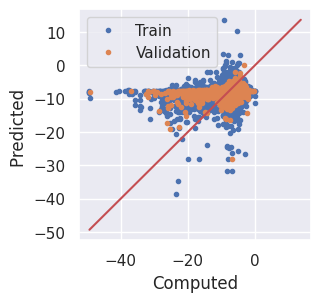

Epoch: 1, Train MAE: 3.3511, Val MAE: 3.4170
Epoch: 2, Train MAE: 3.2543, Val MAE: 3.3908
Epoch: 3, Train MAE: 3.2277, Val MAE: 3.4035
Epoch: 4, Train MAE: 3.2174, Val MAE: 3.3599
Epoch: 5, Train MAE: 3.1953, Val MAE: 3.3510
Epoch: 6, Train MAE: 3.1787, Val MAE: 3.3336
Epoch: 7, Train MAE: 3.1621, Val MAE: 3.3269
Epoch: 8, Train MAE: 3.1672, Val MAE: 3.3214
Epoch: 9, Train MAE: 3.1412, Val MAE: 3.3023
Epoch: 10, Train MAE: 3.1311, Val MAE: 3.3062


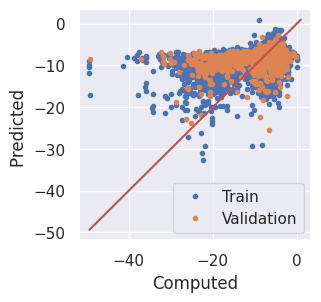

Epoch: 11, Train MAE: 3.1194, Val MAE: 3.3078
Epoch: 12, Train MAE: 3.1209, Val MAE: 3.2922
Epoch: 13, Train MAE: 3.1209, Val MAE: 3.2936
Epoch: 14, Train MAE: 3.0997, Val MAE: 3.2868
Epoch: 15, Train MAE: 3.0839, Val MAE: 3.2866
Epoch: 16, Train MAE: 3.0946, Val MAE: 3.2796
Epoch: 17, Train MAE: 3.0798, Val MAE: 3.2672
Epoch: 18, Train MAE: 3.0849, Val MAE: 3.2558
Epoch: 19, Train MAE: 3.0541, Val MAE: 3.2502
Epoch: 20, Train MAE: 3.0593, Val MAE: 3.2595


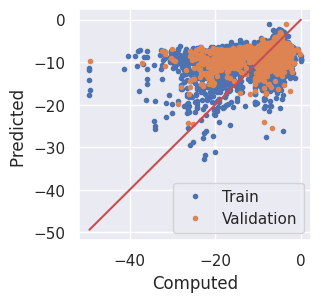

Epoch: 21, Train MAE: 3.0527, Val MAE: 3.2416
Epoch: 22, Train MAE: 3.0367, Val MAE: 3.2355
Epoch: 23, Train MAE: 3.0430, Val MAE: 3.2237
Epoch: 24, Train MAE: 3.0285, Val MAE: 3.2439
Epoch: 25, Train MAE: 3.0398, Val MAE: 3.2327
Epoch: 26, Train MAE: 3.0298, Val MAE: 3.2164
Epoch: 27, Train MAE: 3.0170, Val MAE: 3.2187
Epoch: 28, Train MAE: 3.0068, Val MAE: 3.2282
Epoch: 29, Train MAE: 3.0408, Val MAE: 3.2100
Epoch: 30, Train MAE: 3.0080, Val MAE: 3.1998


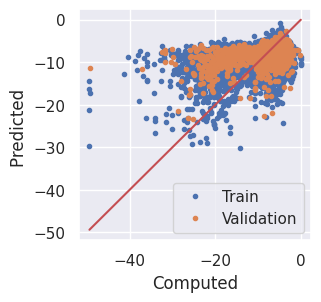

Epoch: 31, Train MAE: 3.0017, Val MAE: 3.2002
Epoch: 32, Train MAE: 3.0044, Val MAE: 3.1943
Epoch: 33, Train MAE: 3.0005, Val MAE: 3.2124
Epoch: 34, Train MAE: 2.9900, Val MAE: 3.1995
Epoch: 35, Train MAE: 2.9853, Val MAE: 3.1867
Epoch: 36, Train MAE: 2.9898, Val MAE: 3.2064
Epoch: 37, Train MAE: 2.9788, Val MAE: 3.1889
Epoch: 38, Train MAE: 2.9813, Val MAE: 3.1979
Epoch: 39, Train MAE: 2.9833, Val MAE: 3.1832
Epoch: 40, Train MAE: 2.9783, Val MAE: 3.1923


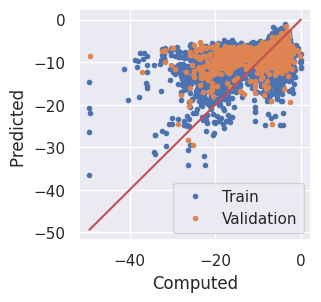

Epoch: 41, Train MAE: 2.9723, Val MAE: 3.1703
Epoch: 42, Train MAE: 2.9502, Val MAE: 3.1867
Epoch: 43, Train MAE: 2.9538, Val MAE: 3.1649
Epoch: 44, Train MAE: 2.9461, Val MAE: 3.1663
Epoch: 45, Train MAE: 2.9518, Val MAE: 3.1592
Epoch: 46, Train MAE: 2.9514, Val MAE: 3.1636
Epoch: 47, Train MAE: 2.9626, Val MAE: 3.1724
Epoch: 48, Train MAE: 2.9566, Val MAE: 3.1642
Epoch: 49, Train MAE: 2.9607, Val MAE: 3.1751
Epoch: 50, Train MAE: 2.9459, Val MAE: 3.1589


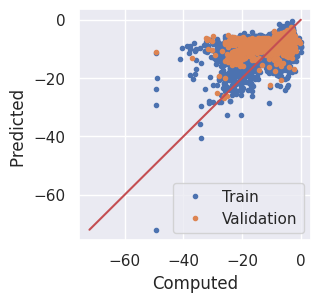

Epoch: 51, Train MAE: 2.9350, Val MAE: 3.1480
Epoch: 52, Train MAE: 2.9249, Val MAE: 3.1695
Epoch: 53, Train MAE: 2.9178, Val MAE: 3.1410
Epoch: 54, Train MAE: 2.9166, Val MAE: 3.1480
Epoch: 55, Train MAE: 2.9404, Val MAE: 3.1334
Epoch: 56, Train MAE: 2.9227, Val MAE: 3.1523
Epoch: 57, Train MAE: 2.9247, Val MAE: 3.1236
Epoch: 58, Train MAE: 2.9165, Val MAE: 3.1259
Epoch: 59, Train MAE: 2.9076, Val MAE: 3.1484
Epoch: 60, Train MAE: 2.9031, Val MAE: 3.1488


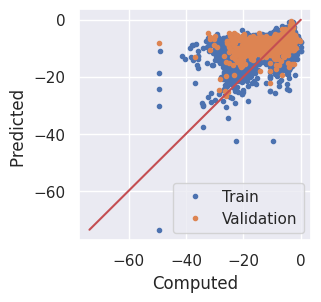

Epoch: 61, Train MAE: 2.9353, Val MAE: 3.1695
Epoch: 62, Train MAE: 2.8940, Val MAE: 3.1595
Epoch: 63, Train MAE: 2.8949, Val MAE: 3.1663
Epoch: 64, Train MAE: 2.8887, Val MAE: 3.1353
Epoch: 65, Train MAE: 2.8875, Val MAE: 3.1654
Epoch: 66, Train MAE: 2.8769, Val MAE: 3.1757
Epoch: 67, Train MAE: 2.8938, Val MAE: 3.1335
Epoch: 68, Train MAE: 2.9043, Val MAE: 3.2788
Epoch: 69, Train MAE: 2.9083, Val MAE: 3.1628
Epoch: 70, Train MAE: 2.8820, Val MAE: 3.1560


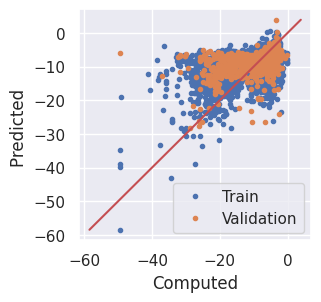

Epoch: 71, Train MAE: 2.8852, Val MAE: 3.1646
Epoch: 72, Train MAE: 2.8782, Val MAE: 3.1425
Epoch: 73, Train MAE: 2.8765, Val MAE: 3.1600
Epoch: 74, Train MAE: 2.8659, Val MAE: 3.1319
Epoch: 75, Train MAE: 2.8509, Val MAE: 3.1455
Epoch: 76, Train MAE: 2.8694, Val MAE: 3.1439
Epoch: 77, Train MAE: 2.8453, Val MAE: 3.1609
Epoch: 78, Train MAE: 2.8686, Val MAE: 3.1648
Epoch: 79, Train MAE: 2.8469, Val MAE: 3.1301
Epoch: 80, Train MAE: 2.8534, Val MAE: 3.1643


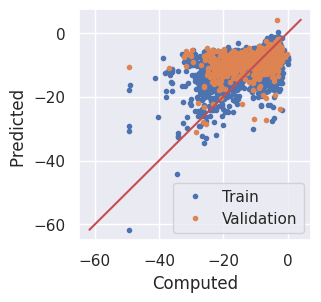

Epoch: 81, Train MAE: 2.8728, Val MAE: 3.1693
Epoch: 82, Train MAE: 2.8456, Val MAE: 3.1212
Epoch: 83, Train MAE: 2.8363, Val MAE: 3.1358
Epoch: 84, Train MAE: 2.8446, Val MAE: 3.1372
Epoch: 85, Train MAE: 2.8718, Val MAE: 3.1213
Epoch: 86, Train MAE: 2.8386, Val MAE: 3.1632
Epoch: 87, Train MAE: 2.8341, Val MAE: 3.1155
Epoch: 88, Train MAE: 2.8436, Val MAE: 3.1135
Epoch: 89, Train MAE: 2.8485, Val MAE: 3.1252
Epoch: 90, Train MAE: 2.8325, Val MAE: 3.1261


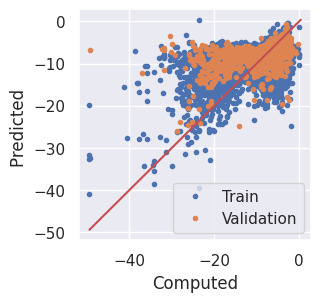

Epoch: 91, Train MAE: 2.8384, Val MAE: 3.1399
Epoch: 92, Train MAE: 2.8491, Val MAE: 3.1412
Epoch: 93, Train MAE: 2.8205, Val MAE: 3.1326
Epoch: 94, Train MAE: 2.8362, Val MAE: 3.1586
Epoch: 95, Train MAE: 2.8111, Val MAE: 3.1320
Epoch: 96, Train MAE: 2.8290, Val MAE: 3.1402
Epoch: 97, Train MAE: 2.8084, Val MAE: 3.1438
Epoch: 98, Train MAE: 2.8148, Val MAE: 3.1177
Epoch: 99, Train MAE: 2.8094, Val MAE: 3.1234
Epoch: 100, Train MAE: 2.8075, Val MAE: 3.1291


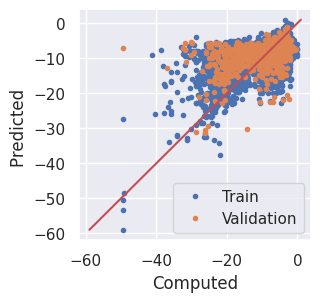

Epoch: 101, Train MAE: 2.7851, Val MAE: 3.1280
Epoch: 102, Train MAE: 2.9254, Val MAE: 3.1327
Epoch: 103, Train MAE: 2.8196, Val MAE: 3.1601
Epoch: 104, Train MAE: 2.8020, Val MAE: 3.1287
Epoch: 105, Train MAE: 2.7868, Val MAE: 3.1211
Epoch: 106, Train MAE: 2.8099, Val MAE: 3.1444
Epoch: 107, Train MAE: 2.7876, Val MAE: 3.1335
Epoch: 108, Train MAE: 2.7985, Val MAE: 3.1270
Epoch: 109, Train MAE: 2.7769, Val MAE: 3.0924
Epoch: 110, Train MAE: 2.7888, Val MAE: 3.1026


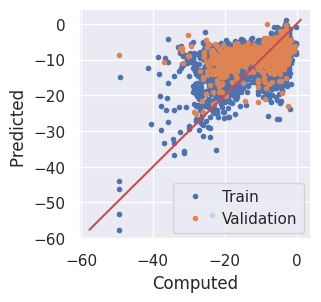

Epoch: 111, Train MAE: 2.7995, Val MAE: 3.1171
Epoch: 112, Train MAE: 2.8071, Val MAE: 3.1191
Epoch: 113, Train MAE: 2.7690, Val MAE: 3.1243
Epoch: 114, Train MAE: 2.7696, Val MAE: 3.1178
Epoch: 115, Train MAE: 2.7695, Val MAE: 3.1174
Epoch: 116, Train MAE: 2.7662, Val MAE: 3.1252
Epoch: 117, Train MAE: 2.7809, Val MAE: 3.1023
Epoch: 118, Train MAE: 2.7827, Val MAE: 3.1163
Epoch: 119, Train MAE: 2.7755, Val MAE: 3.1224
Epoch: 120, Train MAE: 2.7857, Val MAE: 3.1080


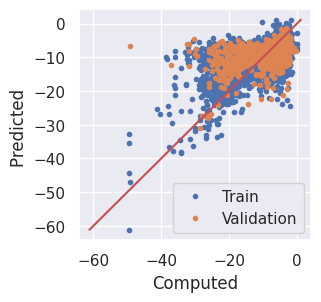

Epoch: 121, Train MAE: 2.7626, Val MAE: 3.0836
Epoch: 122, Train MAE: 2.7630, Val MAE: 3.1079
Epoch: 123, Train MAE: 2.7593, Val MAE: 3.1182
Epoch: 124, Train MAE: 2.7571, Val MAE: 3.1349
Epoch: 125, Train MAE: 2.7842, Val MAE: 3.1316
Epoch: 126, Train MAE: 2.7630, Val MAE: 3.1230
Epoch: 127, Train MAE: 2.7455, Val MAE: 3.1192
Epoch: 128, Train MAE: 2.7766, Val MAE: 3.0929
Epoch: 129, Train MAE: 2.7548, Val MAE: 3.0888
Epoch: 130, Train MAE: 2.7532, Val MAE: 3.0942


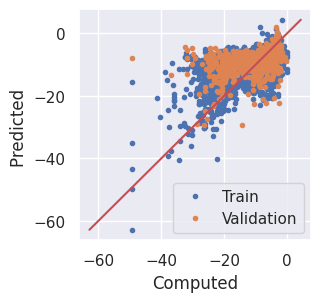

Epoch: 131, Train MAE: 2.7353, Val MAE: 3.1099
Epoch: 132, Train MAE: 2.7512, Val MAE: 3.1225
Epoch: 133, Train MAE: 2.7492, Val MAE: 3.0952
Epoch: 134, Train MAE: 2.7442, Val MAE: 3.1273
Epoch: 135, Train MAE: 2.7349, Val MAE: 3.1187
Epoch: 136, Train MAE: 2.7464, Val MAE: 3.1391
Epoch: 137, Train MAE: 2.7652, Val MAE: 3.1374
Epoch: 138, Train MAE: 2.7437, Val MAE: 3.0994
Epoch: 139, Train MAE: 2.7419, Val MAE: 3.1291
Epoch: 140, Train MAE: 2.8017, Val MAE: 3.0983


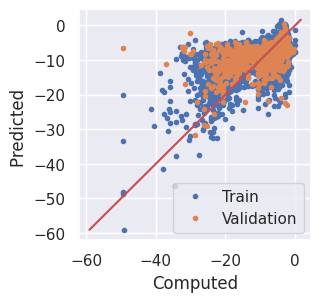

Epoch: 141, Train MAE: 2.7416, Val MAE: 3.0986
Epoch: 142, Train MAE: 2.7227, Val MAE: 3.0990
Epoch: 143, Train MAE: 2.7354, Val MAE: 3.1026
Epoch: 144, Train MAE: 2.7175, Val MAE: 3.1136
Epoch: 145, Train MAE: 2.7208, Val MAE: 3.1525
Epoch: 146, Train MAE: 2.7249, Val MAE: 3.0946
Epoch: 147, Train MAE: 2.7528, Val MAE: 3.0924
Epoch: 148, Train MAE: 2.7257, Val MAE: 3.0853
Epoch: 149, Train MAE: 2.7078, Val MAE: 3.1109
Epoch: 150, Train MAE: 2.7075, Val MAE: 3.1055


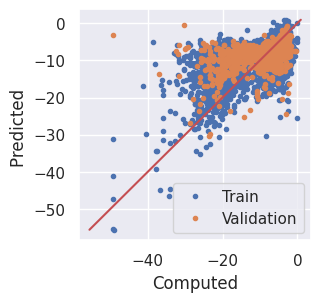

Epoch: 151, Train MAE: 2.7326, Val MAE: 3.1110
Epoch: 152, Train MAE: 2.7063, Val MAE: 3.1036
Epoch: 153, Train MAE: 2.7232, Val MAE: 3.1203
Epoch: 154, Train MAE: 2.7336, Val MAE: 3.1222
Epoch: 155, Train MAE: 2.7112, Val MAE: 3.0911
Epoch: 156, Train MAE: 2.7186, Val MAE: 3.0920
Epoch: 157, Train MAE: 2.7012, Val MAE: 3.1264
Epoch: 158, Train MAE: 2.7231, Val MAE: 3.1274
Epoch: 159, Train MAE: 2.7344, Val MAE: 3.1071
Epoch: 160, Train MAE: 2.7025, Val MAE: 3.1038


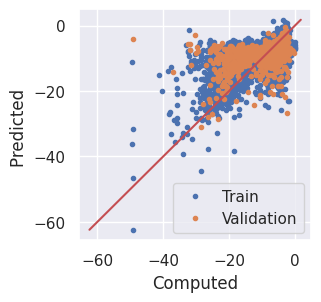

Epoch: 161, Train MAE: 2.7266, Val MAE: 3.1186
Epoch: 162, Train MAE: 2.7101, Val MAE: 3.0998
Epoch: 163, Train MAE: 2.6971, Val MAE: 3.1017
Epoch: 164, Train MAE: 2.7072, Val MAE: 3.1075
Epoch: 165, Train MAE: 2.6895, Val MAE: 3.0802
Epoch: 166, Train MAE: 2.7148, Val MAE: 3.0996
Epoch: 167, Train MAE: 2.7009, Val MAE: 3.0885
Epoch: 168, Train MAE: 2.7052, Val MAE: 3.0491
Epoch: 169, Train MAE: 2.7235, Val MAE: 3.0790
Epoch: 170, Train MAE: 2.6952, Val MAE: 3.0819


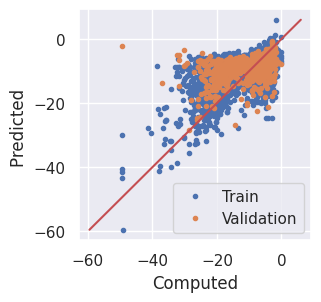

Epoch: 171, Train MAE: 2.6869, Val MAE: 3.0985
Epoch: 172, Train MAE: 2.6939, Val MAE: 3.0787
Epoch: 173, Train MAE: 2.6972, Val MAE: 3.1144
Epoch: 174, Train MAE: 2.7110, Val MAE: 3.0865
Epoch: 175, Train MAE: 2.6814, Val MAE: 3.1086
Epoch: 176, Train MAE: 2.6951, Val MAE: 3.1054
Epoch: 177, Train MAE: 2.7027, Val MAE: 3.1248
Epoch: 178, Train MAE: 2.7894, Val MAE: 3.1391
Epoch: 179, Train MAE: 2.7044, Val MAE: 3.1451
Epoch: 180, Train MAE: 2.7102, Val MAE: 3.1764


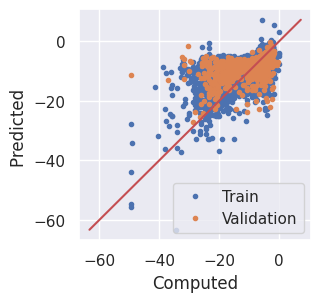

Epoch: 181, Train MAE: 2.7704, Val MAE: 3.0865
Epoch: 182, Train MAE: 2.6845, Val MAE: 3.0746
Epoch: 183, Train MAE: 2.6798, Val MAE: 3.0843
Epoch: 184, Train MAE: 2.6856, Val MAE: 3.1189
Epoch: 185, Train MAE: 2.6744, Val MAE: 3.1020
Epoch: 186, Train MAE: 2.6677, Val MAE: 3.1196
Epoch: 187, Train MAE: 2.6743, Val MAE: 3.1346
Epoch: 188, Train MAE: 2.6568, Val MAE: 3.0948
Epoch: 189, Train MAE: 2.6599, Val MAE: 3.0913
Epoch: 190, Train MAE: 2.7054, Val MAE: 3.1149


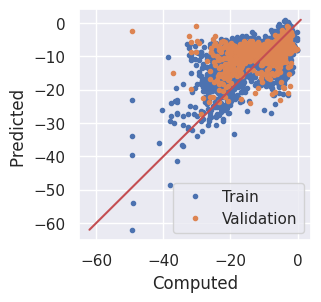

Epoch: 191, Train MAE: 2.6571, Val MAE: 3.1232
Epoch: 192, Train MAE: 2.6991, Val MAE: 3.1002
Epoch: 193, Train MAE: 2.6702, Val MAE: 3.0771
Epoch: 194, Train MAE: 2.6837, Val MAE: 3.0567
Epoch: 195, Train MAE: 2.6710, Val MAE: 3.0880
Epoch: 196, Train MAE: 2.6543, Val MAE: 3.1133
Epoch: 197, Train MAE: 2.6665, Val MAE: 3.0977
Epoch: 198, Train MAE: 2.6804, Val MAE: 3.0685
Epoch: 199, Train MAE: 2.7012, Val MAE: 3.1035
Epoch: 200, Train MAE: 2.6891, Val MAE: 3.0905


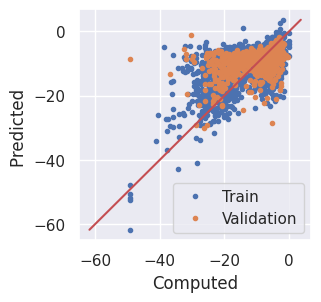

Epoch: 201, Train MAE: 2.6638, Val MAE: 3.0922
Epoch: 202, Train MAE: 2.6765, Val MAE: 3.1200
Epoch: 203, Train MAE: 2.6582, Val MAE: 3.0900
Epoch: 204, Train MAE: 2.6814, Val MAE: 3.0842
Epoch: 205, Train MAE: 2.7023, Val MAE: 3.1314
Epoch: 206, Train MAE: 2.6966, Val MAE: 3.0746
Epoch: 207, Train MAE: 2.6594, Val MAE: 3.0535
Epoch: 208, Train MAE: 2.6671, Val MAE: 3.1204
Epoch: 209, Train MAE: 2.6513, Val MAE: 3.0887
Epoch: 210, Train MAE: 2.7110, Val MAE: 3.1068


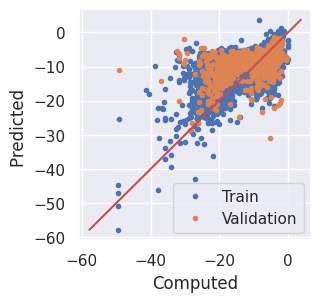

Epoch: 211, Train MAE: 2.6717, Val MAE: 3.0753
Epoch: 212, Train MAE: 2.6484, Val MAE: 3.0823
Epoch: 213, Train MAE: 2.6722, Val MAE: 3.1130
Epoch: 214, Train MAE: 2.6544, Val MAE: 3.0933
Epoch: 215, Train MAE: 2.6588, Val MAE: 3.0942
Epoch: 216, Train MAE: 2.6514, Val MAE: 3.1212
Epoch: 217, Train MAE: 2.6624, Val MAE: 3.0915
Epoch: 218, Train MAE: 2.6594, Val MAE: 3.1378
Epoch: 219, Train MAE: 2.6747, Val MAE: 3.0881
Epoch: 220, Train MAE: 2.6573, Val MAE: 3.0848


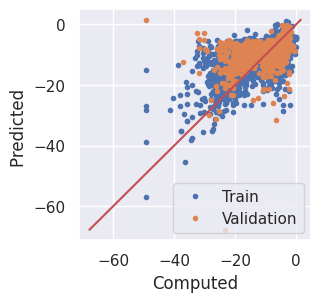

Epoch: 221, Train MAE: 2.6718, Val MAE: 3.2098
Epoch: 222, Train MAE: 2.6472, Val MAE: 3.0763
Epoch: 223, Train MAE: 2.6444, Val MAE: 3.1156
Epoch: 224, Train MAE: 2.6602, Val MAE: 3.0868
Epoch: 225, Train MAE: 2.6403, Val MAE: 3.1049
Epoch: 226, Train MAE: 2.6348, Val MAE: 3.1502
Epoch: 227, Train MAE: 2.6764, Val MAE: 3.0479
Epoch: 228, Train MAE: 2.6427, Val MAE: 3.1337
Epoch: 229, Train MAE: 2.6395, Val MAE: 3.1148
Epoch: 230, Train MAE: 2.6284, Val MAE: 3.1211


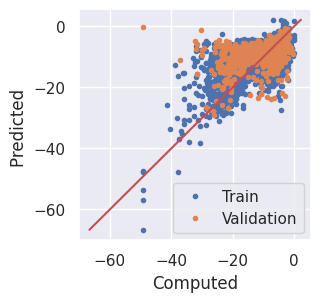

Epoch: 231, Train MAE: 2.6094, Val MAE: 3.1369
Epoch: 232, Train MAE: 2.6443, Val MAE: 3.1236
Epoch: 233, Train MAE: 2.6342, Val MAE: 3.0807
Epoch: 234, Train MAE: 2.6321, Val MAE: 3.0863
Epoch: 235, Train MAE: 2.6711, Val MAE: 3.0972
Epoch: 236, Train MAE: 2.6608, Val MAE: 3.1106
Epoch: 237, Train MAE: 2.6670, Val MAE: 3.1205
Epoch: 238, Train MAE: 2.6235, Val MAE: 3.1113
Epoch: 239, Train MAE: 2.6367, Val MAE: 3.0820
Epoch: 240, Train MAE: 2.6379, Val MAE: 3.1437


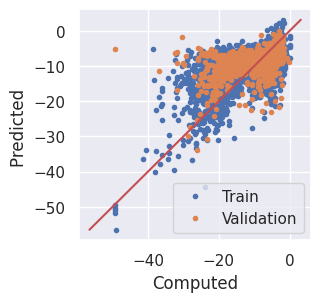

Epoch: 241, Train MAE: 2.6336, Val MAE: 3.0907
Epoch: 242, Train MAE: 2.6432, Val MAE: 3.1725
Epoch: 243, Train MAE: 2.6428, Val MAE: 3.1287
Epoch: 244, Train MAE: 2.6404, Val MAE: 3.1025
Epoch: 245, Train MAE: 2.6430, Val MAE: 3.0899
Epoch: 246, Train MAE: 2.6360, Val MAE: 3.0952
Epoch: 247, Train MAE: 2.6242, Val MAE: 3.1149
Epoch: 248, Train MAE: 2.6317, Val MAE: 3.0835
Epoch: 249, Train MAE: 2.6428, Val MAE: 3.1052
Epoch: 250, Train MAE: 2.6394, Val MAE: 3.0955


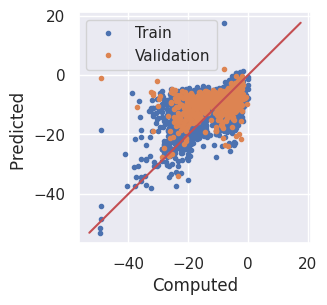

Epoch: 251, Train MAE: 2.6499, Val MAE: 3.1091
Epoch: 252, Train MAE: 2.6537, Val MAE: 3.0761
Epoch: 253, Train MAE: 2.6185, Val MAE: 3.1553
Epoch: 254, Train MAE: 2.6229, Val MAE: 3.0909
Epoch: 255, Train MAE: 2.6215, Val MAE: 3.1068
Epoch: 256, Train MAE: 2.6144, Val MAE: 3.0950
Epoch: 257, Train MAE: 2.6407, Val MAE: 3.1842
Epoch: 258, Train MAE: 2.6689, Val MAE: 3.1212
Epoch: 259, Train MAE: 2.6309, Val MAE: 3.0860
Epoch: 260, Train MAE: 2.6358, Val MAE: 3.1139


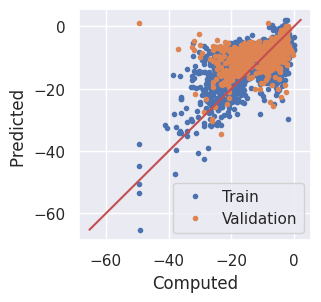

Epoch: 261, Train MAE: 2.5931, Val MAE: 3.1078
Epoch: 262, Train MAE: 2.7644, Val MAE: 3.1686
Epoch: 263, Train MAE: 2.6733, Val MAE: 3.0760
Epoch: 264, Train MAE: 2.6040, Val MAE: 3.1028
Epoch: 265, Train MAE: 2.6065, Val MAE: 3.1236
Epoch: 266, Train MAE: 2.6101, Val MAE: 3.0628
Epoch: 267, Train MAE: 2.6148, Val MAE: 3.0767
Epoch: 268, Train MAE: 2.6510, Val MAE: 3.1513
Epoch: 269, Train MAE: 2.6571, Val MAE: 3.0934
Epoch: 270, Train MAE: 2.6258, Val MAE: 3.1010


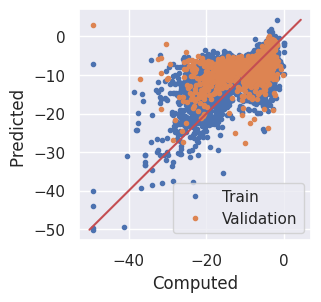

Epoch: 271, Train MAE: 2.6081, Val MAE: 3.1165
Epoch: 272, Train MAE: 2.6082, Val MAE: 3.1117
Epoch: 273, Train MAE: 2.6023, Val MAE: 3.0882
Epoch: 274, Train MAE: 2.5967, Val MAE: 3.0889
Epoch: 275, Train MAE: 2.6005, Val MAE: 3.0948
Epoch: 276, Train MAE: 2.6208, Val MAE: 3.1451
Epoch: 277, Train MAE: 2.6159, Val MAE: 3.0924
Epoch: 278, Train MAE: 2.6092, Val MAE: 3.0903
Epoch: 279, Train MAE: 2.6216, Val MAE: 3.1033
Epoch: 280, Train MAE: 2.5968, Val MAE: 3.1111


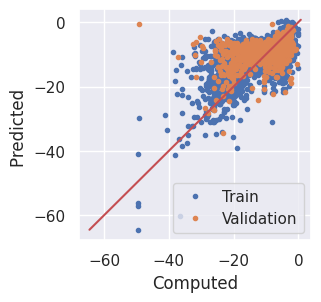

Epoch: 281, Train MAE: 2.6363, Val MAE: 3.0556
Epoch: 282, Train MAE: 2.6217, Val MAE: 3.0983
Epoch: 283, Train MAE: 2.6062, Val MAE: 3.0985
Epoch: 284, Train MAE: 2.6576, Val MAE: 3.0819
Epoch: 285, Train MAE: 2.6358, Val MAE: 3.0856
Epoch: 286, Train MAE: 2.6040, Val MAE: 3.0717
Epoch: 287, Train MAE: 2.6062, Val MAE: 3.1181
Epoch: 288, Train MAE: 2.5762, Val MAE: 3.1406
Epoch: 289, Train MAE: 2.5953, Val MAE: 3.1004
Epoch: 290, Train MAE: 2.6148, Val MAE: 3.0942


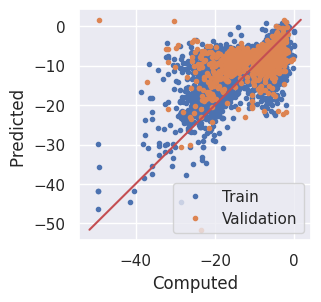

Epoch: 291, Train MAE: 2.6121, Val MAE: 3.1327
Epoch: 292, Train MAE: 2.5958, Val MAE: 3.1102
Epoch: 293, Train MAE: 2.6396, Val MAE: 3.1084
Epoch: 294, Train MAE: 2.6802, Val MAE: 3.0635
Epoch: 295, Train MAE: 2.6196, Val MAE: 3.0441
Epoch: 296, Train MAE: 2.5947, Val MAE: 3.0750
Epoch: 297, Train MAE: 2.5904, Val MAE: 3.1233
Epoch: 298, Train MAE: 2.6027, Val MAE: 3.0633
Epoch: 299, Train MAE: 2.5975, Val MAE: 3.0833
Epoch: 300, Train MAE: 2.6217, Val MAE: 3.0777


In [9]:
# Train the model
train_losses = []
val_losses   = []
for epoch in np.arange(0, n_epochs):
    train_loss, train_predictions, train_ground_truths = clm.train(model, criterion, train_loader,
                                                                   target_factor,
                                                                   standardized_parameters['target_mean'],
                                                                   optimizer)
    val_loss,   val_predictions,   val_ground_truths   =  clm.test(model, criterion, val_loader,
                                                                   target_factor,
                                                                   standardized_parameters['target_mean'])

    # Convert to original units
    train_loss = np.sum(np.sqrt(train_loss) * target_factor)
    val_loss   = np.sum(np.sqrt(val_loss)   * target_factor)

    if epoch%10 == 0:
        cld.parity_plot(train=np.array([train_ground_truths, train_predictions]),
                        validation=np.array([val_ground_truths, val_predictions]))
    
    # Append losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Check early stopping criteria
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    print(f'Epoch: {epoch+1}, Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}')

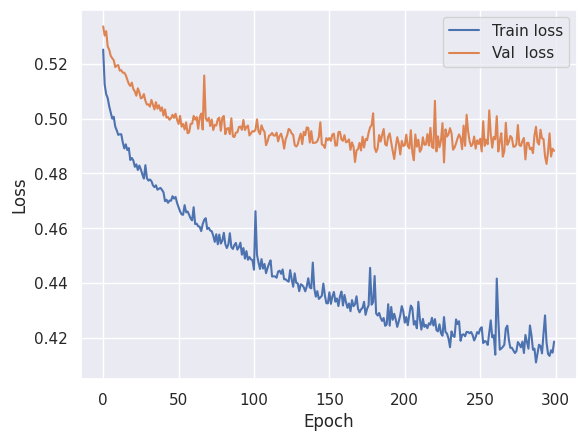

In [10]:
cld.losses_plot(train_losses=train_losses,
                val_losses=val_losses,
                to_log=True)

# Check test data

In [ ]:
model = clm.load_model(n_node_features, dropout, device, model_name=files_names['model_name'], purpose='eval')
model

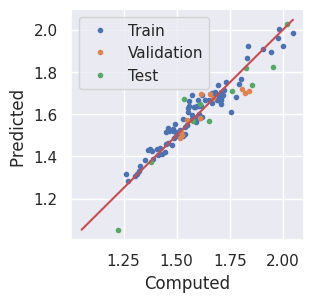

Train MAE: 0.0446, Val MAE: 0.0682, Test MAE: 0.0904


In [9]:
train_loss, train_predictions, train_ground_truths = clm.test(model, criterion, train_loader,
                                                              target_factor,
                                                              standardized_parameters['target_mean'])
val_loss,   val_predictions,   val_ground_truths   =  clm.test(model, criterion, val_loader,
                                                               target_factor,
                                                               standardized_parameters['target_mean'])
test_loss,  test_predictions,  test_ground_truths  =  clm.test(model, criterion, test_loader,
                                                               target_factor,
                                                               standardized_parameters['target_mean'])

# Pass to energy units (same as initial Fv)
train_loss = np.sum(np.sqrt(train_loss) * target_factor)
val_loss   = np.sum(np.sqrt(val_loss)   * target_factor)
test_loss  = np.sum(np.sqrt(test_loss)  * target_factor)

cld.parity_plot(train=np.array([train_ground_truths, train_predictions]),
                validation=np.array([val_ground_truths, val_predictions]),
                test=np.array([test_ground_truths, test_predictions]),
                save_to=f'{target_folder}/{target}-GCNN-training.pdf')

print(f'Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}, Test MAE: {test_loss:.4f}')

# Generate uncertainties and save

In [10]:
dataset = [data for dataset in [train_dataset, val_dataset, test_dataset] for data in dataset]

loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

loss, predictions, ground_truths = clm.test(model, criterion, loader,
                                            target_factor,
                                            standardized_parameters['target_mean'])

# label: uncertainty = ground-truth - prediction
uncertainties = ground_truths - predictions

# Standardize for better interpolation
uncertainties_std = (uncertainties - standardized_parameters['target_mean']) * standardized_parameters['scale'] / standardized_parameters['target_std']

# Generate dictionary with uncertainty data
uncertainty_data = {}
for idx in range(len(dataset)):
    uncertainty_data.update(
        {dataset[idx].label: float(uncertainties_std[idx])}
    )

# Dump the dictionary with numpy arrays to a JSON file
cld.save_json(uncertainty_data, files_names['uncert_data_name'])